In [198]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [199]:
dataset = pd.read_excel('data/data.xlsx')
empty_data = dataset.dropna(how='all')
empty_data = empty_data.dropna(axis=1,how='all')
empty_data = empty_data.drop([0])
empty_data = empty_data.reset_index()
empty_data = empty_data.drop(columns=['L,p','index'])
dataset = empty_data

In [200]:
#Set equal label type for sick people
for i, row in dataset.iterrows():
    label = row['rozpoznanie']
    if label == ' s':
        dataset.at[i,'rozpoznanie'] = 's'
    elif label == 'S':
        dataset.at[i,'rozpoznanie'] = 's'

In [201]:
sick = dataset[(dataset['rozpoznanie']=='s')]
obese = dataset[(dataset['rozpoznanie']=='o')]
healthy = dataset[(dataset['rozpoznanie']=='k')]

In [202]:
#For rows where there is no age or weight, put random age generated from normal distribution with mean age and standard deviation of age
for set in [sick, obese, healthy]:
    mean_age = set[['wiek']].mean()
    std_age = set[['wiek']].std()
    for i, row in set.iterrows():
        (weight, age) = row[['masa ciała','wiek']]
        if  pd.isnull(age):
            new_age = np.random.normal(mean_age,std_age)
            set.at[i,'wiek'] = new_age
        if (age < 5) and (weight > 40):
            new_age = np.random.normal(mean_age,std_age)
            set.at[i,'wiek'] = new_age
  

In [203]:
obese.describe()

,wiek,masa ciała,wzrost,BMI,średnia dla wieku,SD populacji,Z score BMI,50 centyl BMI,stłuszczenie w %,zapalenie,...,EPA,C22:2n-6,C22:4n-6,C22:5n-6,C24:0,C24:1n-9,C22:5n-3,DHA,AA/DGLA,DGLA/LA
count,78.000000,61.000000,61.000000,60.000000,29.000000,28.000000,27.000000,27.000000,0.0,0.0,...,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,13.952558,80.379508,2.052672,28.751185,20.317586,2.650000,2.118041,19.711111,NaN,NaN,...,0.229615,0.349359,0.372949,0.708718,0.235385,0.778846,0.618590,2.071667,2.524582,0.144844
std,3.120481,22.001271,2.991857,3.492173,1.575125,0.324893,3.188732,1.588258,NaN,NaN,...,0.193535,0.092895,0.074539,0.239026,0.106071,0.215539,0.218357,0.347221,0.772456,0.030449
min,2.270000,1.800000,0.980000,18.670000,15.830000,1.510000,-8.868852,15.400000,NaN,NaN,...,0.090000,0.190000,0.220000,0.140000,0.100000,0.390000,0.320000,1.310000,1.160714,0.069312
25%,12.014885,73.000000,1.650000,26.345205,19.810000,2.500000,1.966616,19.400000,NaN,NaN,...,0.132500,0.280000,0.320000,0.470000,0.142500,0.612500,0.440000,1.915000,1.868529,0.123871
50%,14.355995,82.000000,1.720000,28.655646,20.790000,2.600000,2.539149,20.500000,NaN,NaN,...,0.170000,0.350000,0.370000,0.750000,0.210000,0.760000,0.570000,2.130000,2.494240,0.141317
75%,16.253540,92.000000,1.773500,31.077500,21.640000,2.787500,3.740889,20.700000,NaN,NaN,...,0.227500,0.407500,0.410000,0.890000,0.310000,0.925000,0.740000,2.315000,2.952756,0.159249
max,20.730194,127.300000,25.000000,38.857178,21.650000,3.300000,5.833074,21.500000,NaN,NaN,...,1.100000,0.560000,0.530000,1.100000,0.500000,1.380000,1.570000,2.690000,4.210526,0.234487


In [204]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [205]:
def predict_weight(set):
    loop=0
    set_to_predict = set[set['masa ciała'].isnull()][['wiek', 'masa ciała']].drop('masa ciała', axis = 1)
    set_train = set[set['masa ciała'].notnull()][['wiek', 'masa ciała']]

    assert set.shape[0] == set_to_predict.shape[0] + set_train.shape[0]

    X = set_train.drop('masa ciała', axis = 1)
    y = set_train['masa ciała']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=515)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_real = scaler.transform(set_to_predict)

    alphas = np.arange(0.001,10,0.01)
    ridge_cv_model = RidgeCV(alphas=alphas,scoring='neg_root_mean_squared_error')
    ridge_cv_model.fit(X_train,y_train)

    test_predictions = ridge_cv_model.predict(X_test)

    MAE = mean_absolute_error(y_test,test_predictions)
    MSE = mean_squared_error(y_test,test_predictions)
    RMSE = np.sqrt(MSE)

    print(f'MAE: {MAE}\nRMSE: {RMSE}')

    real_predictions = ridge_cv_model.predict(X_real)

    sick_to_predict = np.squeeze(set_to_predict)

    sns.scatterplot(x=sick_to_predict, y=real_predictions)
    sns.scatterplot(data=set_train, x='wiek', y='masa ciała')
    if loop == 0:
        plt.title('Sick')
    elif loop == 1:
        plt.title('Obese')
    elif loop == 2:
        plt.title('Healthy')
    plt.show()

    loop +=1
    for i, row in set.iterrows():
        (weight, age) = row[['masa ciała','wiek']]
        if  pd.isnull(weight):
            new_weight = ridge_cv_model.predict(scaler.transform(np.reshape(a = np.array(age),newshape = (1,-1))))
            #
            set.at[i,'masa ciała'] = new_weight


MAE: 14.67582946589105
RMSE: 16.700754484925774


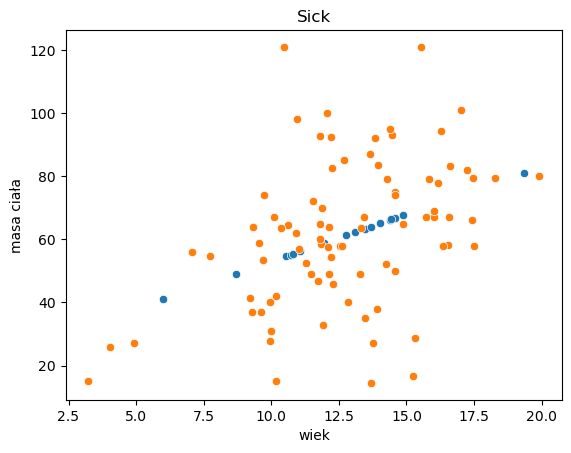

c:\Users\Kubi\anaconda3\envs\ml_course\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Kubi\anaconda3\envs\ml_course\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Kubi\anaconda3\envs\ml_course\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Kubi\anaconda3\envs\ml_course\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Kubi\anaconda3\envs\ml_course\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Kubi\anaconda3\envs\m

MAE: 20.12039233198529
RMSE: 34.08507029500049


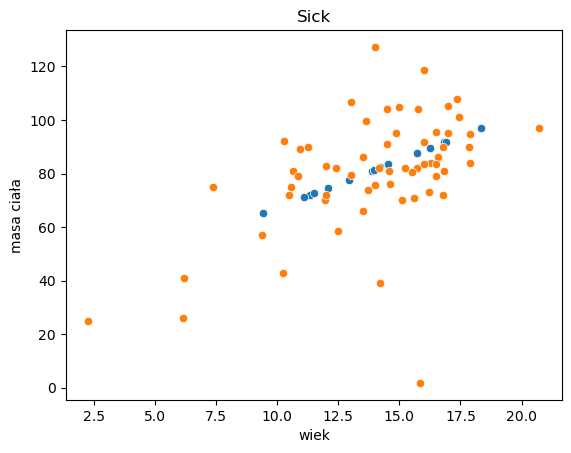

c:\Users\Kubi\anaconda3\envs\ml_course\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Kubi\anaconda3\envs\ml_course\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Kubi\anaconda3\envs\ml_course\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Kubi\anaconda3\envs\ml_course\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Kubi\anaconda3\envs\ml_course\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Kubi\anaconda3\envs\m

MAE: 10.777792676754103
RMSE: 11.627626580881037


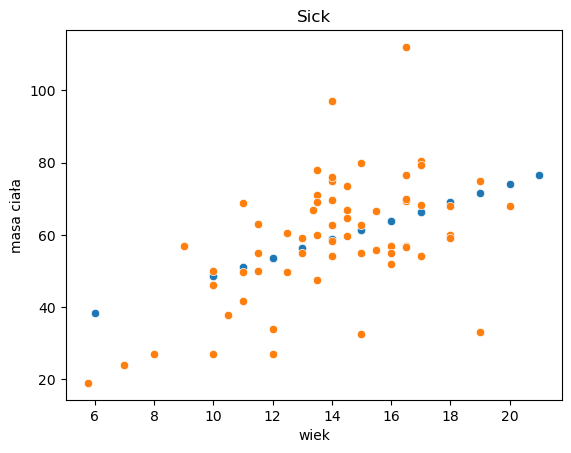

c:\Users\Kubi\anaconda3\envs\ml_course\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Kubi\anaconda3\envs\ml_course\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Kubi\anaconda3\envs\ml_course\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Kubi\anaconda3\envs\ml_course\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Kubi\anaconda3\envs\ml_course\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Kubi\anaconda3\envs\m

In [206]:
for set in [sick, obese, healthy]:
    predict_weight(set)

<Axes: xlabel='wiek', ylabel='masa ciała'>

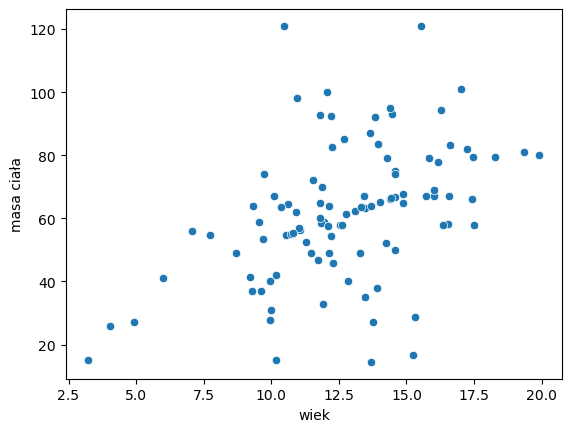

In [209]:
sns.scatterplot(data=sick, x='wiek', y='masa ciała')

In [159]:
#Count no-age
nr_of_no_age = 0
mean_age = dataset[['wiek']].mean()
std_age = dataset[['wiek']].std()
for i, row in dataset.iterrows():
    (weight, age) = row[['masa ciała','wiek']]
    if not(pd.isnull(weight)) and pd.isnull(age):
        nr_of_no_age+=1
nr_of_no_age

28

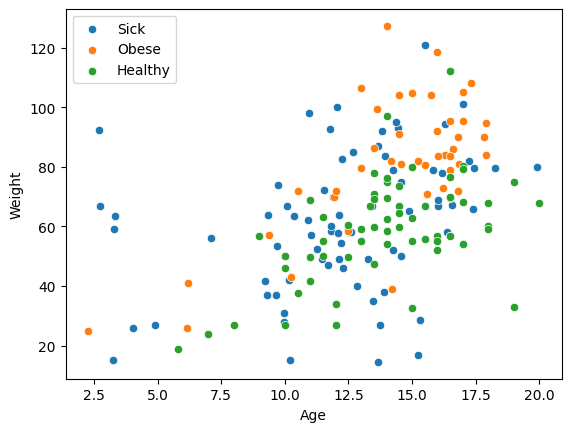

In [151]:
sick = dataset[['wiek','masa ciała', 'rozpoznanie']][(dataset['rozpoznanie']=='s')]
obese = dataset[['wiek','masa ciała', 'rozpoznanie']][(dataset['rozpoznanie']=='o')]
healthy = dataset[['wiek','masa ciała', 'rozpoznanie']][(dataset['rozpoznanie']=='k')]
sns.scatterplot(data=sick, x = 'wiek', y='masa ciała', label= 'Sick')
sns.scatterplot(data=obese, x = 'wiek', y='masa ciała', label = 'Obese' )
sns.scatterplot(data=healthy, x = 'wiek', y='masa ciała', label = 'Healthy')
plt.xlabel('Age')
plt.ylabel('Weight')
plt.legend(loc=2)